In [1]:
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 5.1 MB/s 
     |████████████████████████████████| 948 kB 34.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=12f807776767c037a4bb229ac6fb18ff14ab4823531c6829299f9c71882ad47d
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import cv2
from PIL import Image
import numpy as np
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/drive')
%matplotlib inline

Mounted at /content/drive


In [15]:
zipFile = zipfile.ZipFile('/content/drive/MyDrive/Datasets/KITTI_lane.zip', 'r')
zipFile.extractall('dataset')
zipFile.close()

Функция для вычисления мат. ожидания и дисперсии для всего датасета

In [ ]:
def get_mean_and_std(data_loader):
  mean = 0
  std = 0
  images_count = 0
  for images, _ in data_loader:
    
    images_in_the_batch = images.size(0)
    images = images.view(images_in_the_batch, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    images_count += images_in_the_batch
  
  mean /= images_count
  std /= images_count
  
  return mean, std

In [ ]:
transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((250,828)),])

loader=DataLoader(
    torchvision.datasets.ImageFolder("/content/drive/MyDrive/Datasets/for_mean_and_std",transform=transform),
    batch_size=16, shuffle=True
)

mean, std = get_mean_and_std(loader)
print(mean)
print(std)

tensor([0.3497, 0.3757, 0.3646])
tensor([0.2854, 0.3031, 0.3155])


При помощи этой ячейки из оригинального датасета были отобраны только изображения, размеченные для сегментации дорожных полос, а не всей дороги

In [ ]:
path = "/content/dataset/KITTI_lane/validation/masks"
new_path = "/content/drive/MyDrive/Datasets/KITTI_lane_masks/"
# path1 = "/content/drive/MyDrive/Datasets/for_mean_and_std/1/"
# path2 = "/content/drive/MyDrive/Datasets/for_mean_and_std/2/"
# path = "/content/dataset/KITTI_dataset/training/images"
masks = os.listdir(path)
# non_road_label = np.array([255, 0, 0])
# road_label = np.array([255, 0, 255])
# other_road_label = np.array([0, 0, 0])

masks = [mask for mask in masks if mask.startswith("um_lane")]
masks.sort()
for mask_path in masks:
  mask = np.array(Image.open(path + "/" + mask_path).convert("L"))
  # mask_path = mask_path.replace("_lane_","_")
  # binary_mask = np.all(mask == road_label, axis = 2)
  # binary_mask = binary_mask.astype(np.float32)
  # binary_mask[binary_mask == 1.0] = 255.0
  # print(binary_mask)
  # cv2_imshow(binary_mask)
  mask[mask != 105.0] = 0.
  mask[mask == 105.0] = 255.0
  cv2.imwrite(new_path + mask_path, mask)

Архитектура Unet

In [3]:
class Conv_block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    return x

class Downsample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv = Conv_block(in_channels, out_channels)
    self.pool = nn.MaxPool2d((2, 2))

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.pool(x)

    return x, p


class Upsample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
    self.conv = Conv_block(out_channels + out_channels, out_channels)

  def forward(self, inputs, skip):
    x = self.up(inputs)
    if x.shape != skip.shape:
      x = TF.resize(x, size=skip.shape[2:])
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)

    return x


class unet(nn.Module):
  def __init__(self):
    super().__init__()


    self.down1 = Downsample(3, 64)
    self.down2 = Downsample(64, 128)
    self.down3 = Downsample(128, 256)
    self.down4 = Downsample(256, 512)


    self.transition = Conv_block(512, 1024)


    self.up1 = Upsample(1024, 512)
    self.up2 = Upsample(512, 256)
    self.up3 = Upsample(256, 128)
    self.up4 = Upsample(128, 64)

   
    self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

  def forward(self, inputs):
    skip1, x = self.down1(inputs)
    skip2, x = self.down2(x)
    skip3, x = self.down3(x)
    skip4, x = self.down4(x)


    x = self.transition(x)


    x = self.up1(x, skip4)
    x = self.up2(x, skip3)
    x = self.up3(x, skip2)
    x = self.up4(x, skip1)


    outputs = self.outputs(x)

    return outputs

In [4]:
class KITTIDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.all_images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
        self.all_images.sort()
        self.masks.sort()
        self.images = []
        for image in self.all_images:
          if image in self.masks:
            self.images.append(image)
        
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
    acc = num_correct/num_pixels
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    dice = dice_score/len(loader)
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

    return acc, dice

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

In [16]:
LEARNING_RATE = 8e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 250  # 375 originally
IMAGE_WIDTH = 828  # 1242 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "/content/dataset/KITTI_lane/training/images"
TRAIN_MASK_DIR = "/content/dataset/KITTI_lane/training/masks"
VAL_IMG_DIR = "/content/dataset/KITTI_lane/validation/images"
VAL_MASK_DIR = "/content/dataset/KITTI_lane/validation/masks"

Из-за малого количество обучающих данных я использовал data augmentation для расширения датасета

In [17]:
train_transforms1 = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.3497, 0.3757, 0.3646],
                std=[0.2854, 0.3031, 0.3155],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

train_transforms2 = A.Compose(
        [
          A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          # A.HorizontalFlip(p=0.5),
          # A.VerticalFlip(p=0.1),
          A.Normalize(
              mean=[0.3497, 0.3757, 0.3646],
              std=[0.2854, 0.3031, 0.3155],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
    )

train_transforms3 = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            # A.HorizontalFlip(p=0.5),
            # A.VerticalFlip(p=0.1),
            A.Blur(blur_limit=5, p=0.5),
            A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, always_apply=False, p=0.5), 
            A.Normalize(
                mean=[0.3497, 0.3757, 0.3646],
                std=[0.2854, 0.3031, 0.3155],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.3497, 0.3757, 0.3646],
                std=[0.2854, 0.3031, 0.3155],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [18]:
train_dataset1 = KITTIDataset(
        image_dir=TRAIN_IMG_DIR,
        mask_dir=TRAIN_MASK_DIR,
        transform=train_transforms1,
    )

train_dataset2 = KITTIDataset(
        image_dir=TRAIN_IMG_DIR,
        mask_dir=TRAIN_MASK_DIR,
        transform=train_transforms2,
    )

train_dataset3 = KITTIDataset(
        image_dir=TRAIN_IMG_DIR,
        mask_dir=TRAIN_MASK_DIR,
        transform=train_transforms3,
    )

train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2, train_dataset3])

train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
    )

val_dataset = KITTIDataset(
        image_dir=VAL_IMG_DIR,
        mask_dir=VAL_MASK_DIR,
        transform=val_transforms,
    )

val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
    )

In [ ]:
model = unet().to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()
for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        
        # check accuracy
        val_acc, dice_score = check_accuracy(val_loader, model, device=DEVICE)

        torch.save(model, f"KITTI_lane_sementation_unet_val_acc={val_acc}_dice={dice_score}")
        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="/content/saved_images/", device=DEVICE
        )

100%|██████████| 33/33 [00:21<00:00,  1.52it/s, loss=0.384]


Got 1782043/1863000 with acc 95.65
Dice score: 0.7289033532142639


100%|██████████| 33/33 [00:21<00:00,  1.52it/s, loss=0.33]


Got 1824814/1863000 with acc 97.95
Dice score: 0.804308295249939


100%|██████████| 33/33 [00:21<00:00,  1.52it/s, loss=0.265]


Got 1839163/1863000 with acc 98.72
Dice score: 0.8451645374298096


100%|██████████| 33/33 [00:21<00:00,  1.51it/s, loss=0.315]


Got 1844360/1863000 with acc 99.00
Dice score: 0.8577624559402466


100%|██████████| 33/33 [00:21<00:00,  1.51it/s, loss=0.24]


Got 1844222/1863000 with acc 98.99
Dice score: 0.9032406806945801


100%|██████████| 33/33 [00:21<00:00,  1.50it/s, loss=0.226]


Got 1839336/1863000 with acc 98.73
Dice score: 0.8434233665466309


100%|██████████| 33/33 [00:22<00:00,  1.50it/s, loss=0.231]


Got 1840677/1863000 with acc 98.80
Dice score: 0.843413233757019


100%|██████████| 33/33 [00:22<00:00,  1.49it/s, loss=0.202]


Got 1844443/1863000 with acc 99.00
Dice score: 0.8723530769348145


100%|██████████| 33/33 [00:22<00:00,  1.48it/s, loss=0.201]


Got 1839993/1863000 with acc 98.77
Dice score: 0.8479995727539062


100%|██████████| 33/33 [00:22<00:00,  1.49it/s, loss=0.191]


Got 1836726/1863000 with acc 98.59
Dice score: 0.8539175391197205


Функция, выделяющая на изображении область перед автомобилем

In [8]:
def region_of_interest(image):
    polygons = np.array([(300, 120),
                         (550, 120),
                         (700, 200),
                         (200, 200)])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, np.array([polygons], dtype=np.int64), 1024)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [9]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1 * (6/10))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [22]:
def calculate_lines(image, lines):

    left_fit = []
    right_fit = []

    while lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            intercept = parameters[1]
            if (slope < 0) & (abs(slope) < 3):
                left_fit.append((slope, intercept))
            elif (slope > 0) & (abs(slope) < 3):
                right_fit.append((slope, intercept))
        if left_fit:
            left_fit_average = np.average(left_fit, axis=0)
            left_line = make_coordinates(image, left_fit_average)
        if right_fit:
            right_fit_average = np.average(right_fit, axis=0)
            right_line = make_coordinates(image, right_fit_average)
        return np.array([left_line, right_line])

In [11]:
def display_lines(image, lines):
    lined_image = np.zeros_like(image)
    if lines is not None:
        i = 1
        for x1, y1, x2, y2 in lines:
            if i == 1:
                cv2.line(lined_image, (x1, y1), (x2, y2), (0, 255, 0), 8)
                i+=1
                p1 = [x1,y1,x2,y2]
            else:
                cv2.line(lined_image, (x1, y1), (x2, y2), (0, 255, 0), 8)
                pts = np.array([[[ p1[0], p1[1]], [p1[2], p1[3]], [x2,y2],[x1,y1]]], dtype=np.int32)
                cv2.fillPoly(lined_image, pts, (202, 255, 192), lineType=8, shift=0, offset=None)
                  
    return lined_image

In [35]:
def predict_mask(img, model):
  img_tensor = TF.to_tensor(img)
  img_tensor = img_tensor.unsqueeze(0)
  img_tensor = img_tensor.to(DEVICE)
  mask = torch.sigmoid(model(img_tensor))
  mask = (mask > 0.5).float()
  mask = mask.squeeze(0).squeeze(0)
  mask = mask.cpu().detach().numpy()
  mask[mask == 1.0] = 255.0
  mask = mask.astype(np.uint8)
  return mask

In [36]:
def process_image(img, model):
  img = cv2.resize(img, (828, 250))
  mask = predict_mask(img, model)

  white = np.array([255, 255, 255])
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
  c = max(contours, key = cv2.contourArea)
  lined_image = np.zeros_like(img)
  lined_image = cv2.drawContours(lined_image, c, 0, (255, 255, 255), thickness = 2)
  cv2.fillPoly(lined_image, [c], (255, 255, 255), lineType=8, shift=0, offset=None)
  binary_mask = np.all(lined_image == white, axis = 2)
  binary_mask = binary_mask.astype(np.uint8)
  binary_mask[binary_mask == 1] = 255

  binary_mask = cv2.Canny(binary_mask, 50, 150)
  binary_mask = region_of_interest(binary_mask)
  lines = cv2.HoughLinesP(binary_mask, 1, np.pi / 180, 20, np.array([()]), minLineLength=10, maxLineGap=10)
  a_lines = calculate_lines(binary_mask, lines)
  lined_image = display_lines(img, a_lines)
  combined_frame = cv2.addWeighted(img, 0.9, lined_image, 0.5, 1)

  return combined_frame

In [13]:
model = torch.load("/content/drive/MyDrive/Models/KITTI_lane_sementation_unet_val_acc=0.9899205565452576_dice=0.9032406806945801")

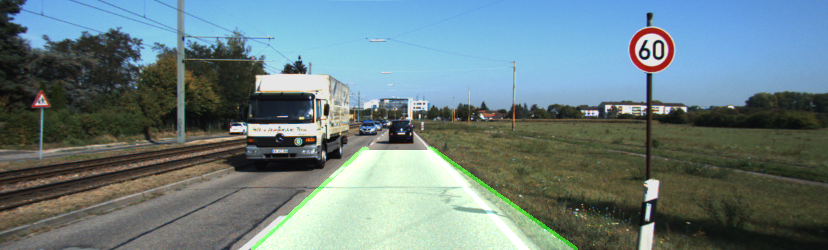

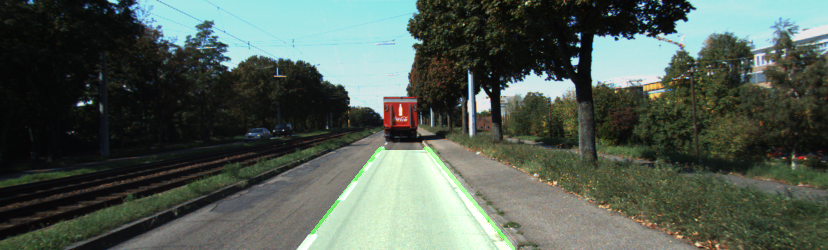

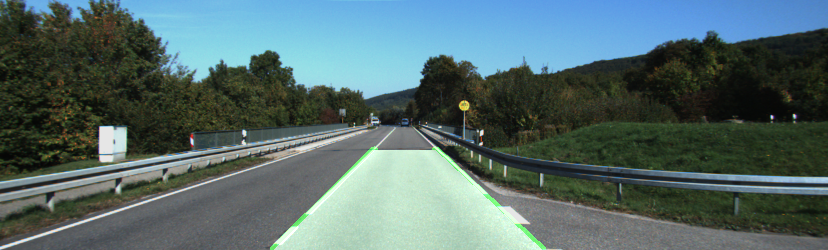

In [37]:
image1 = cv2.imread("/content/dataset/KITTI_lane/validation/images/um_000037.png")
image2 = cv2.imread("/content/dataset/KITTI_lane/validation/images/um_000047.png")
image3 = cv2.imread("/content/dataset/KITTI_lane/validation/images/um_000067.png")
image1 = process_image(image1, model)
image2 = process_image(image2, model)
image3 = process_image(image3, model)
cv2_imshow(image1)
cv2_imshow(image2)
cv2_imshow(image3)

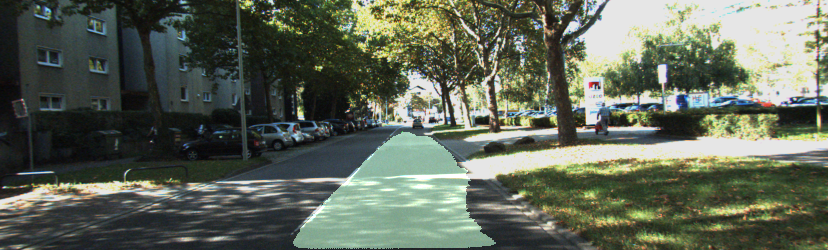

In [38]:
img = cv2.imread("/content/dataset/KITTI_lane/validation/images/um_000077.png")
img = cv2.resize(img, (828, 250))
mask = predict_mask(img, model)

contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
c = max(contours, key = cv2.contourArea)
lined_image = np.zeros_like(img)
lined_image = cv2.drawContours(lined_image, c, 0, (0, 255, 0), thickness = 2)
cv2.fillPoly(lined_image, [c], (202, 255, 192), lineType=8, shift=0, offset=None)
combined_frame = cv2.addWeighted(img, 0.9, lined_image, 0.5, 1)
cv2_imshow(combined_frame)